In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from scipy import ndimage
import seaborn as sns


# Linear landscape

/tmp/ipykernel_44844/3824238281.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  'viridis_range', cm.get_cmap('coolwarm')(np.linspace(0, 1, 256)), N=256


Search space 823543


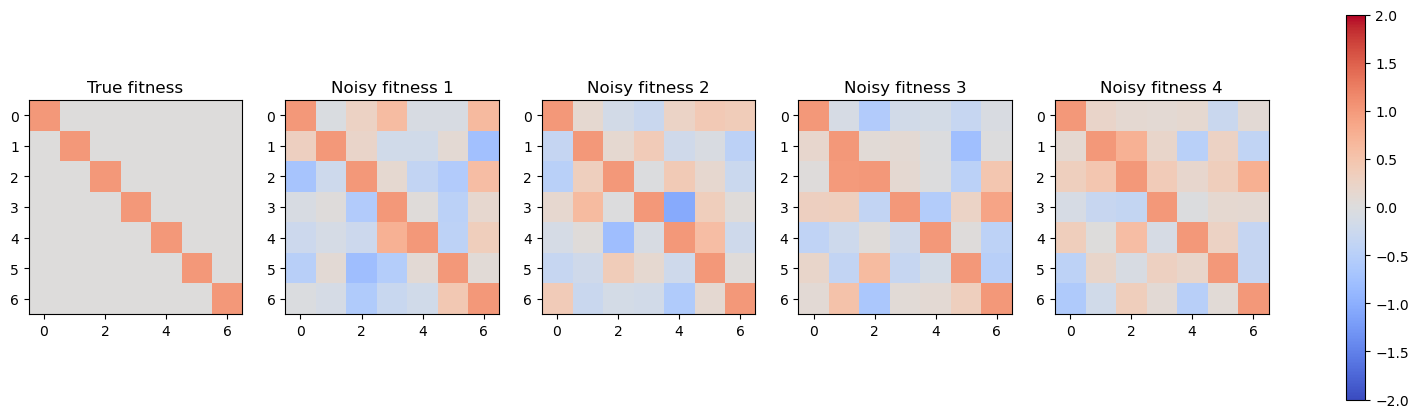

In [119]:
np.random.seed(42)

# Plotting functions. Thank you GPT.
viridis_range = colors.LinearSegmentedColormap.from_list(
    'viridis_range', cm.get_cmap('coolwarm')(np.linspace(0, 1, 256)), N=256
)

cmap = colors.LinearSegmentedColormap('viridis', colors.Normalize(-2, 2), 100)
num_measurements = 4
noise_scale = 0.4
fig, axes = plt.subplots(1, 1+num_measurements, figsize=(num_measurements*5, 5))
plt_imshow = lambda a,x: a.imshow(x, cmap=viridis_range, interpolation='nearest', vmin=-2, vmax=2)

# Sample different fitness landscapes
n = 7
print(f'Search space {n**n}')
reward = np.eye(n)
im = plt_imshow(axes[0], reward)
axes[0].set_title('True fitness')
all_noisy_landscapes = []
for i in range(1, 1+num_measurements):
    noisy_reward_vec = reward + (1 - reward)*np.random.normal(scale=noise_scale, size=(n,n))
    _ = plt_imshow(axes[i], noisy_reward_vec)
    _ = axes[i].set_title(f'Noisy fitness {i}')
    all_noisy_landscapes.append(noisy_reward_vec)
fig.colorbar(im, ax=axes.ravel().tolist())

In [121]:
def true_noep_reward(x):
    return np.sum(x*np.eye(n), axis=(-1,-2))

In [131]:
def true_noep_reward(x):
    return np.sum(x*np.eye(n), axis=(-1,-2))
noisy_reward_vec = reward + (1 - np.eye(n))*np.random.normal(scale=noise_scale, size=(n,n))
def noisy_noep_reward(x):
    return np.sum(x * noisy_reward_vec, axis=(-1, -2))


In [14]:
alphabet = 'ABCDEFG'

In [17]:
num_examples = 1000
seen_seqs = set()
data = []
n = 7
while len(data) < num_examples:
    oh_seq = np.eye(n)
    oh_seq = np.apply_along_axis(np.random.permutation, 1, oh_seq)
    oh_seq_str = ''.join(map(str, oh_seq))
    #sum of diagonal elements can be at most 2
    if np.sum(np.diag(oh_seq)) > 1 or oh_seq_str in seen_seqs:
        continue
    #convert to 2d array, then to string sequence based on alphabet above
    seen_seqs.add(oh_seq_str)
    seq_tokens = np.argmax(oh_seq, axis = 1)
    seq = ''.join([alphabet[i] for i in seq_tokens])
    seq_reward = reward(oh_seq)
    data.append((seq, seq_reward))



In [20]:
landscape_epistasis = pd.DataFrame(data, columns = ['sequence', 'target'])
landscape_one_max['augmented'] = 0
landscape_one_max.to_csv('/home/gridsan/akirjner/protein_design/GGS-private/data/Diagonal/ground_truth_one_max.csv', index=False)

In [25]:
correct_seq = 'ABCDEFG'
landscape = pd.DataFrame(data, columns = ['sequence', 'target'])
all_seqs = landscape['sequence'].values
num_correct_tokens = [sum([1 if seq[i] == correct_seq[i] else 0 for i in range(len(correct_seq))]) for seq in all_seqs]
fitness_df = pd.DataFrame({
    'correct token': num_correct_tokens,
    'total fitness': landscape.target.values
})


In [30]:
landscape['augmented'] = 0
landscape.to_csv('/home/gridsan/akirjner/protein_design/GGS-private/data/Diagonal/ground_truth.csv', index=False)

# Epistatic effect

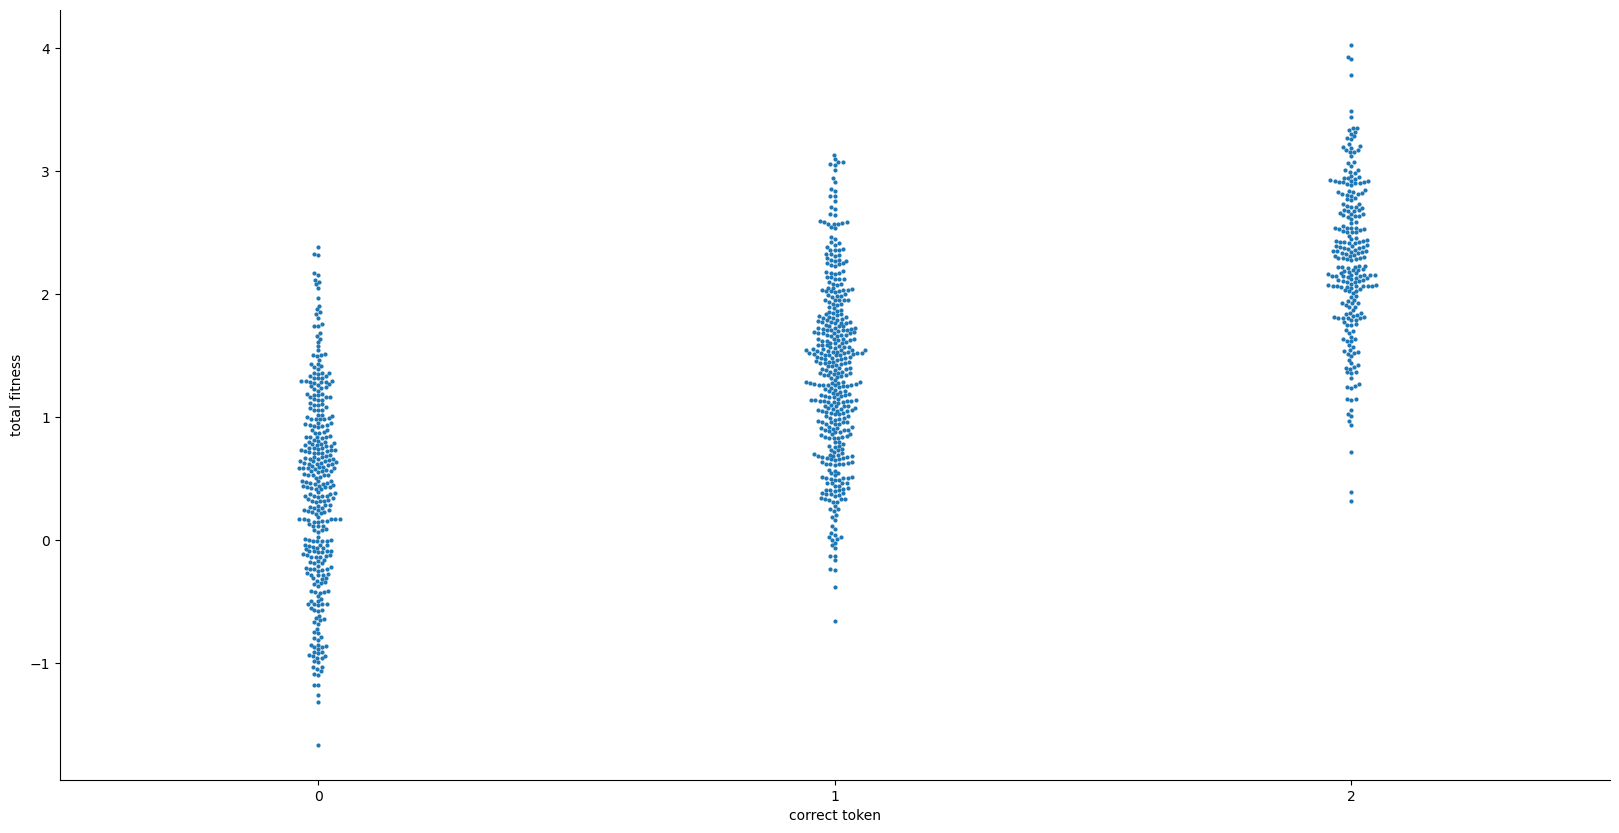

In [28]:
plt.figure(figsize=(20,10))
sns.swarmplot(data=fitness_df, x='correct token', y='total fitness', s=3)
sns.despine()

In [110]:
np.random.seed(40)
n = 7
noise_scale = 0.4
first_order_reward = np.eye(n)
first_order_reward[:2] *= -1
noisy_first_order_rewards = [] 
num_replicates = 3
for _ in range(num_replicates):
    noisy_first_order_rewards.append(first_order_reward + (1 - np.eye(n))*np.random.normal(scale=noise_scale, size=(n,n)))


second_order_reward_1 = np.eye(n)
second_order_reward_1[2:] = 0

def noisy_reward(x, replicate = 0):
    """x is the one-hot sequence of shape [B, N, D].
    
    B: batch size.
    N: sequence length.
    D: vocab length.
    
    Returns a [B] dimensional tensor of the fitness of each sequence.
    """
    fitness = np.sum(x * noisy_first_order_rewards[replicate][None], axis=(-1, -2))
    fitness += (np.sum(second_order_reward_1[None] * x, axis=(-1, -2)) == 2) * 4
    return fitness

def true_reward(x):
    """x is the one-hot sequence of shape [B, N, D].
    
    B: batch size.
    N: sequence length.
    D: vocab length.
    
    Returns a [B] dimensional tensor of the fitness of each sequence.
    """
    fitness = np.sum(x * first_order_reward[None], axis=(-1, -2))
    fitness += (np.sum(second_order_reward_1[None] * x, axis=(-1, -2)) == 2) * 4
    return fitness



In [68]:
num_examples = 1000
seen_seqs = set()
data = []
n = 7
num_replicates = 3
while len(data) < num_examples:
    oh_seq = np.eye(n)
    oh_seq = np.apply_along_axis(np.random.permutation, 1, oh_seq)
    oh_seq_str = ''.join(map(str, oh_seq))
    # #sum of diagonal elements can be at most 2
    # if np.sum(np.diag(oh_seq)) > 2 or oh_seq_str in seen_seqs:
    #     continue
    #convert to 2d array, then to string sequence based on alphabet above
    seen_seqs.add(oh_seq_str)
    seq_tokens = np.argmax(oh_seq, axis = 1)
    
    seq = ''.join([alphabet[i] for i in seq_tokens])
    for i in range(num_replicates):
        seq_reward = noisy_reward(oh_seq, i)[0]
        data.append((seq, seq_reward))

In [69]:
landscape_epistasis = pd.DataFrame(data, columns = ['sequence', 'target'])
landscape_epistasis['augmented'] = 0
landscape_epistasis.to_csv('/home/gridsan/akirjner/protein_design/GGS-private/data/Diagonal/ground_truth_epistasis_replicates.csv', index=False)

In [43]:
gt = pd.read_csv('/home/gridsan/akirjner/protein_design/GGS-private/data/Diagonal/ground_truth.csv')

In [46]:
gt_seqs = gt.sequence
gt_oh = []
for seq in gt_seqs:
    gt_oh.append(np.array([np.array([1 if char == letter else 0 for char in alphabet]) for letter in seq]))
gt_oh = np.array(gt_oh)
    
gt_oracle = oracle_reward(gt_oh)

(array([345.,   0.,   0.,   0.,   0., 409.,   0.,   0.,   0., 246.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

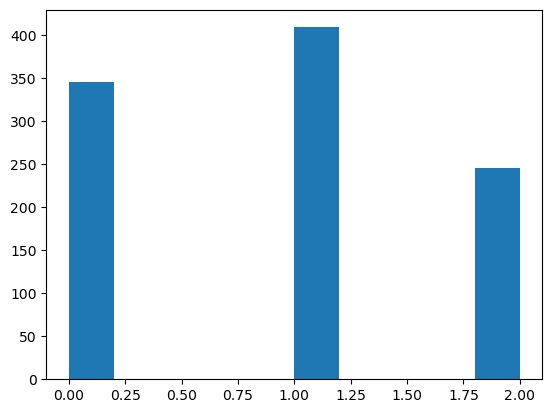

In [47]:
plt.hist(gt_oracle)

In [111]:
n = 7
unsmoothed_df = pd.read_csv("/home/gridsan/akirjner/protein_design/GGS-private/ckpt//Diagonal/mutations_0/percentile_0.0_1.0/unsmoothed/run_07D_08M_2023Y_12h_16m_26s/samples/run_2023-08-07_12-47/seed_1.csv")
#Get mutant_sequences corresponding to top 100 values in the mutant_scores column in unsmoothed_df

alphabet = 'ABCDEFG'

unsmoothed_median_scores = []
unsmoothed_noisy_median_scores = []
for epoch in unsmoothed_df['epoch'].unique():
    epoch_df = unsmoothed_df[unsmoothed_df['epoch'] == epoch]
    top_100_unsmoothed_one_hot = []
    seen_seqs = set()
    for seq in epoch_df.sort_values(by=['mutant_scores'], ascending=False)['mutant_sequences'].tolist():
        if seq in seen_seqs:
            continue
        seen_seqs.add(seq)
        top_100_unsmoothed_one_hot.append(np.array([np.array([1 if char == letter else 0 for char in alphabet]) for letter in seq]))

        if len(top_100_unsmoothed_one_hot) == 128:
            break

    top_100_unsmoothed_one_hot = np.array(top_100_unsmoothed_one_hot)
    unsmoothed_scores = true_reward(top_100_unsmoothed_one_hot)
    unsmoothed_noisy_scores = noisy_reward(top_100_unsmoothed_one_hot)
    unsmoothed_median_scores.append(np.mean(unsmoothed_scores))
    unsmoothed_noisy_median_scores.append(np.mean(unsmoothed_noisy_scores))


In [113]:
smoothed_df = pd.read_csv("/home/gridsan/akirjner/protein_design/GGS-private/ckpt/Diagonal/mutations_0/percentile_0.0_1.0/smoothed/epistasis_5_evecs/samples/run_2023-08-07_16-00/seed_1.csv")
#Get mutant_sequences corresponding to top 100 values in the mutant_scores column in unsmoothed_df

alphabet = 'ABCDEFG'
#now convert them each to np arrays one-hot
smoothed_median_scores = []
smoothed_noisy_median_scores = []
for epoch in smoothed_df['epoch'].unique():
    epoch_df = smoothed_df[smoothed_df['epoch'] == epoch]
    top_100_smoothed_one_hot = []
    seen_seqs = set()
    for seq in epoch_df.sort_values(by=['mutant_scores'], ascending=False)['mutant_sequences'].tolist():
        if seq in seen_seqs:
            continue
        seen_seqs.add(seq)
        top_100_smoothed_one_hot.append(np.array([np.array([1 if char == letter else 0 for char in alphabet]) for letter in seq]))

        if len(top_100_smoothed_one_hot) == 128:
            break

    top_100_smoothed_one_hot = np.array(top_100_smoothed_one_hot)
    smoothed_scores = true_reward(top_100_smoothed_one_hot)
    smoothed_noisy_scores = noisy_reward(top_100_smoothed_one_hot)
    smoothed_median_scores.append(np.mean(smoothed_scores))
    smoothed_noisy_median_scores.append(np.mean(smoothed_noisy_scores))


Text(0.5, 1.0, 'Mean Fitness of Top 128 Seqs According to Predictor vs. Epoch (EPISTATIC LANDSCAPE)')

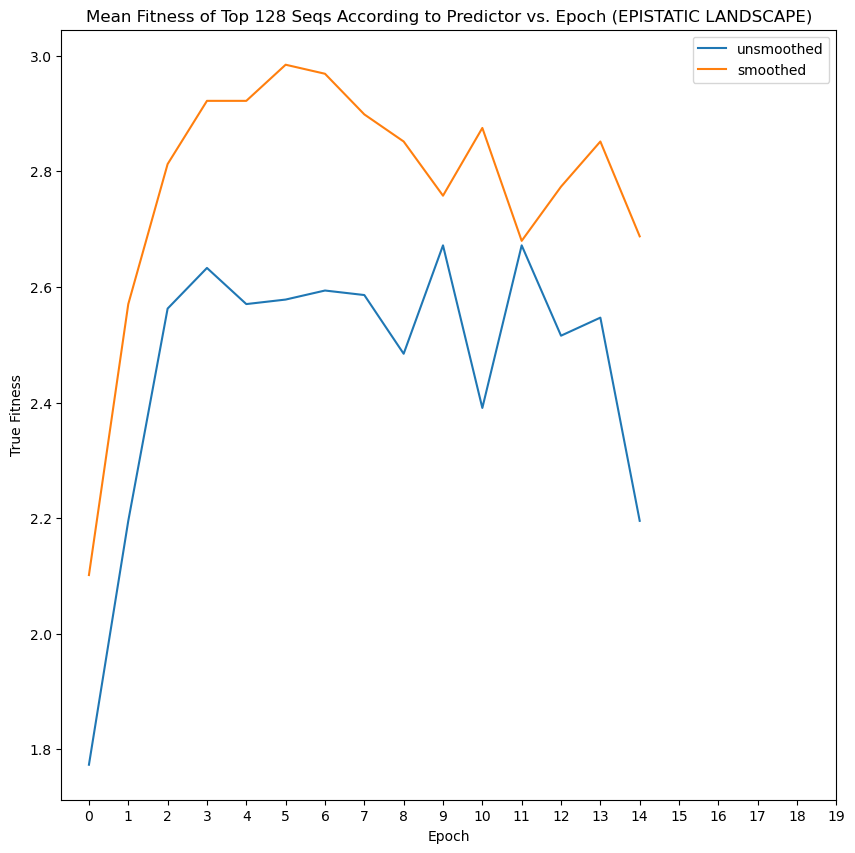

In [115]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(np.arange(0, len(unsmoothed_median_scores)), unsmoothed_median_scores, label='unsmoothed')
plt.plot(np.arange(0, len(smoothed_median_scores)), smoothed_median_scores, label='smoothed')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("True Fitness")
plt.xticks(np.arange(20))
plt.title("Mean Fitness of Top 128 Seqs According to Predictor vs. Epoch (EPISTATIC LANDSCAPE)")

Text(0.5, 1.0, 'Mean Noisy Fitness of Top 128 Seqs According to Predictor vs. Epoch (EPISTATIC LANDSCAPE)')

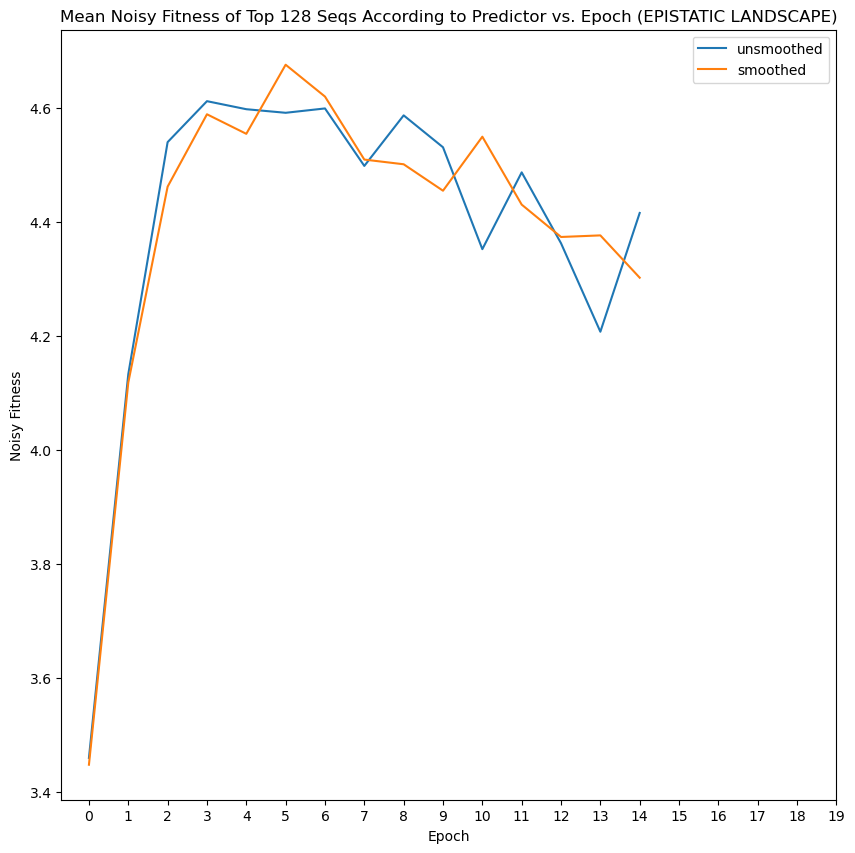

In [117]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(np.arange(0, len(unsmoothed_median_scores)), unsmoothed_nosiy_median_scores, label='unsmoothed')
plt.plot(np.arange(0, len(smoothed_median_scores)), smoothed_noisy_median_scores, label='smoothed')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Noisy Fitness")
plt.xticks(np.arange(20))
plt.title("Mean Noisy Fitness of Top 128 Seqs According to Predictor vs. Epoch (EPISTATIC LANDSCAPE)")

In [132]:
n = 7
unsmoothed_df = pd.read_csv("/home/gridsan/akirjner/protein_design/GGS-private/ckpt//Diagonal/mutations_0/percentile_0.0_1.0/unsmoothed/run_07D_08M_2023Y_12h_16m_26s/samples/run_2023-08-07_12-47/seed_1.csv")
#Get mutant_sequences corresponding to top 100 values in the mutant_scores column in unsmoothed_df

alphabet = 'ABCDEFG'

unsmoothed_median_scores = []
unsmoothed_noisy_median_scores = []
for epoch in unsmoothed_df['epoch'].unique():
    epoch_df = unsmoothed_df[unsmoothed_df['epoch'] == epoch]
    top_100_unsmoothed_one_hot = []
    seen_seqs = set()
    for seq in epoch_df.sort_values(by=['mutant_scores'], ascending=False)['mutant_sequences'].tolist():
        if seq in seen_seqs:
            continue
        seen_seqs.add(seq)
        top_100_unsmoothed_one_hot.append(np.array([np.array([1 if char == letter else 0 for char in alphabet]) for letter in seq]))

        # if len(top_100_unsmoothed_one_hot) == 128:
        #     break

    top_100_unsmoothed_one_hot = np.array(top_100_unsmoothed_one_hot)
    unsmoothed_scores = true_noep_reward(top_100_unsmoothed_one_hot)
    unsmoothed_noisy_scores = noisy_noep_reward(top_100_unsmoothed_one_hot)
    unsmoothed_median_scores.append(np.mean(unsmoothed_scores))
    unsmoothed_noisy_median_scores.append(np.mean(unsmoothed_noisy_scores))


In [133]:
smoothed_df = pd.read_csv("/home/gridsan/akirjner/protein_design/GGS-private/ckpt/Diagonal/mutations_0/percentile_0.0_1.0/smoothed/no_epistasis_5_evecs/samples/run_2023-08-07_16-11/seed_1.csv")
#Get mutant_sequences corresponding to top 100 values in the mutant_scores column in unsmoothed_df

alphabet = 'ABCDEFG'
#now convert them each to np arrays one-hot
smoothed_median_scores = []
smoothed_noisy_median_scores = []
for epoch in smoothed_df['epoch'].unique():
    epoch_df = smoothed_df[smoothed_df['epoch'] == epoch]
    top_100_smoothed_one_hot = []
    seen_seqs = set()
    for seq in epoch_df.sort_values(by=['mutant_scores'], ascending=False)['mutant_sequences'].tolist():
        if seq in seen_seqs:
            continue
        seen_seqs.add(seq)
        top_100_smoothed_one_hot.append(np.array([np.array([1 if char == letter else 0 for char in alphabet]) for letter in seq]))

        # if len(top_100_smoothed_one_hot) == 128:
        #     break

    top_100_smoothed_one_hot = np.array(top_100_smoothed_one_hot)
    smoothed_scores = true_noep_reward(top_100_smoothed_one_hot)
    smoothed_noisy_scores = noisy_noep_reward(top_100_smoothed_one_hot)
    smoothed_median_scores.append(np.mean(smoothed_scores))
    smoothed_noisy_median_scores.append(np.mean(smoothed_noisy_scores))


Text(0.5, 1.0, 'Mean Fitness of Top 128 Seqs According to Predictor vs. Epoch (NON-EPISTATIC LANDSCAPE)')

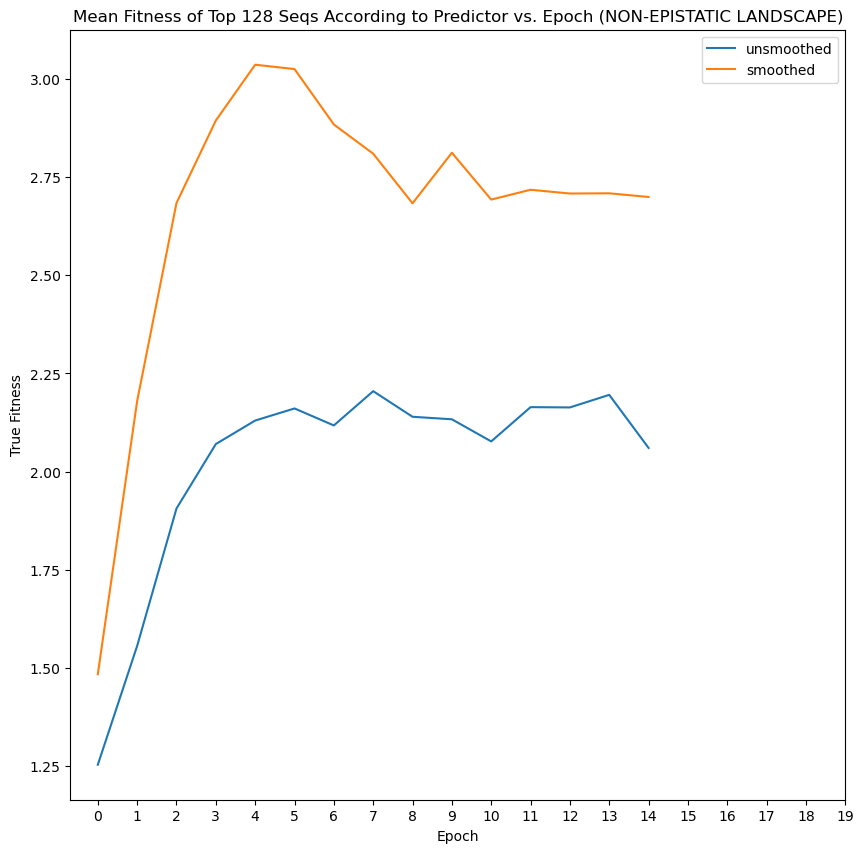

In [134]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(np.arange(0, len(unsmoothed_median_scores)), unsmoothed_median_scores, label='unsmoothed')
plt.plot(np.arange(0, len(smoothed_median_scores)), smoothed_median_scores, label='smoothed')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("True Fitness")
plt.xticks(np.arange(20))
plt.title("Mean Fitness of Top 128 Seqs According to Predictor vs. Epoch (NON-EPISTATIC LANDSCAPE)")

Text(0.5, 1.0, 'Mean Noisy Fitness of Top 128 Seqs According to Predictor vs. Epoch (NON_EPISTATIC LANDSCAPE)')

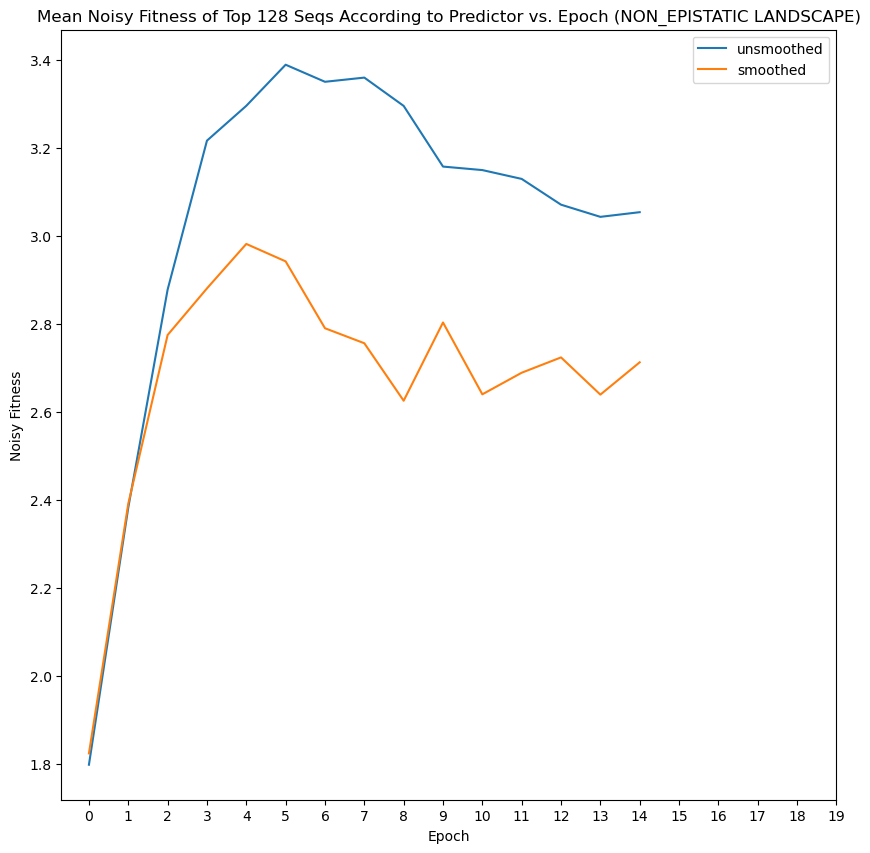

In [137]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(np.arange(0, len(unsmoothed_median_scores)), unsmoothed_noisy_median_scores, label='unsmoothed')
plt.plot(np.arange(0, len(smoothed_median_scores)), smoothed_noisy_median_scores, label='smoothed')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Noisy Fitness")
plt.xticks(np.arange(20))
plt.title("Mean Noisy Fitness of Top 128 Seqs According to Predictor vs. Epoch (NON_EPISTATIC LANDSCAPE)")

In [60]:
epistasis_training_set = pd.read_csv('/home/gridsan/akirjner/protein_design/GGS-private/data/Diagonal/ground_truth_epistasis.csv')

(array([  8.,  31., 103., 175., 224., 201., 147.,  72.,  36.,   3.]),
 array([-2.72270137, -2.05088974, -1.37907812, -0.7072665 , -0.03545487,
         0.63635675,  1.30816837,  1.97998   ,  2.65179162,  3.32360324,
         3.99541487]),
 <BarContainer object of 10 artists>)

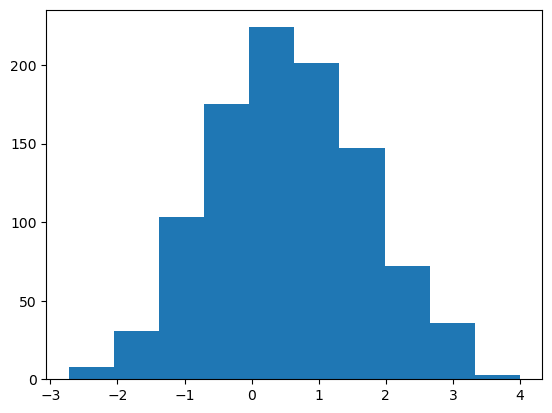

In [61]:
plt.hist(epistasis_training_set.target)

# Double epistatic effect

In [74]:
np.random.seed(40)
n = 7
noise_scale = 0.4
first_order_reward = np.eye(n)
first_order_reward[:4] *= -1
noisy_first_order_reward = first_order_reward + (1 - np.eye(n))*np.random.normal(scale=noise_scale, size=(n,n))

second_order_reward_1 = np.eye(n)
second_order_reward_1[2:] = 0

second_order_reward_2 = np.eye(n)
second_order_reward_2[:2] = 0
second_order_reward_2[4:] = 0


def reward(x):
    fitness = np.sum(x * noisy_first_order_reward[None], axis=(-1, -2))
    fitness += (np.sum(second_order_reward_1[None] * x, axis=(-1, -2)) == 2) * 4
    fitness += (np.sum(second_order_reward_2[None] * x, axis=(-1, -2)) == 2) * 4
    return fitness

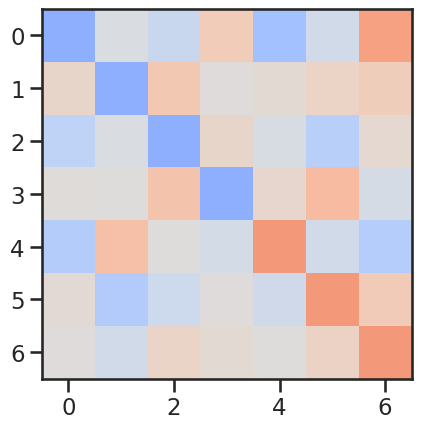

In [70]:
plt.imshow(noisy_first_order_reward, cmap=viridis_range, interpolation='nearest', vmin=-2, vmax=2)

# Analyze

In [100]:
np.random.seed(11)
all_seqs = []
num_points = int(5e3)
print(num_points)
for _ in range(num_points):
    seq = np.eye(n)[np.random.permutation(np.arange(n))]
    all_seqs.append(seq)
all_seqs = np.stack(all_seqs)

5000


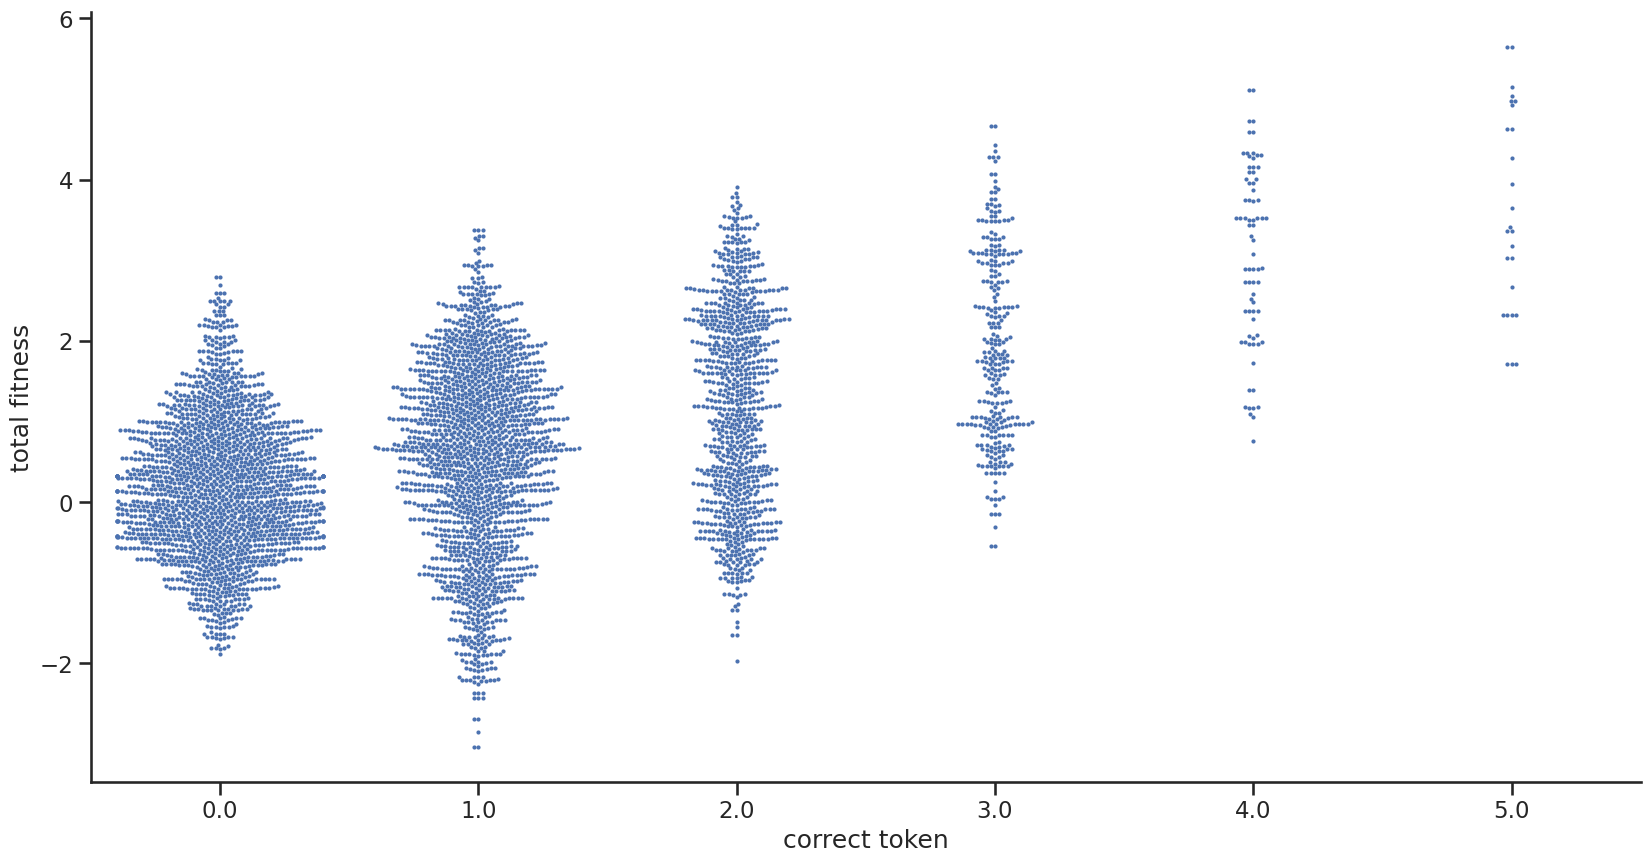

In [101]:
fitness = all_seqs * all_noisy_landscapes[2][None]
total_fitness = reward(all_seqs)
correct_tokens = np.sum(all_seqs * np.eye(n), axis=(-1, -2))

fitness_df = pd.DataFrame({
    'correct token': correct_tokens,
    'total fitness': total_fitness
})

sns.set(style='ticks', context='talk')
iris = sns.load_dataset('iris')

plt.figure(figsize=(20,10))
sns.swarmplot(data=fitness_df, x='correct token', y='total fitness', s=3)
sns.despine()